<a href="https://colab.research.google.com/github/ivame/DANO_final/blob/main/Data_Sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
def make_group(event: str):
  # Посещение корзины с последующим оформлением заказа
  g1 = ['Посещение корзины с добавленными товарами', 'Ввод промокода']

  # 1е шаги оформления
  g2 = ['Клик на кнопку Перейти к оформлению', 'Выбор радиобаттона eSIM', 'Выбор радиобаттона обычной SIM']

  # Изменение тарифа
  g3 = ['Выбор другого тарифа или номера в корзине']

  # Ввод личных данных
  g4 = ['Ввод контактного номера', 'Ввод имени', 'Ввод email',
        'Клик на кнопку Продолжить 1 (Экран ввода контактных данных)', 'Клик на кнопку Продолжить 2 (Экран выбора региона)']

  # Оформление доставки
  g5 = ['Клик на кнопку Продолжить 3 (Экран выбора способа получения)', 'Клик на кнопку Продолжить 4 (Экран выбора адреса доставки/самовывоза)']

  # Заполнение паспортных данных
  g6 = ['Включение блока паспортных данных', 'Успешное заполнение всех полей паспортных данных']

  # Покупка
  g7 = ['Покупка']

  if event in g1:
    return 1
  elif event in g2:
    return 2
  elif event in g3:
    return 3
  elif event in g4:
    return 4
  elif event in g5:
    return 5
  elif event in g6:
    return 6
  elif event in g7:
    return 7

In [27]:
def group_region(region_data):
  # Удаляем регионы с телефонной плотностью больше 225, так как они очень отличаются от основнй выборки
  largest_regions = region_data[region_data['telephone_density']>225]['region_name'].to_list()
  region_data = region_data[region_data.region_name.isin(largest_regions) == False]

  # Найдем границы 25, 50 и 75 перцентелей
  sorted_data = sorted(region_data['telephone_density'])
  q1 = np.percentile(sorted_data, 25)
  q2 = np.percentile(sorted_data, 50)
  q3 = np.percentile(sorted_data, 75)


  # Поделим данные по границам выбраных перцентилей
  mini_regions = region_data[region_data['telephone_density']<=q1]['region_name'].to_list()
  small_regions = region_data.loc[(region_data['telephone_density'] > q1) &(region_data['telephone_density'] <= q2)]['region_name'].to_list()
  standart_regions = region_data.loc[(region_data['telephone_density'] > q2) &(region_data['telephone_density'] <= q3)]['region_name'].to_list()
  big_regions = region_data[region_data['telephone_density']>=q3]['region_name'].to_list()

  return (mini_regions, small_regions, standart_regions, big_regions, largest_regions)

In [28]:
# Группировка по региону
def make_reg(region: str, mini_regions: list, small_regions: list, standart_regions: list,
             big_regions: list, largest_regions: list):
  if region in mini_regions:
    return 'mini_regions'
  elif region in small_regions:
    return 'small_regions'
  elif region in standart_regions:
    return 'standart_regions'
  elif region in big_regions:
    return 'big_regions'
  elif region in largest_regions:
    return 'largest_regions'

In [29]:
df = pd.read_csv('/content/drive/MyDrive/Dano/plotnost-podvizhnoj-svyazi-2022.csv', sep=';', skipinitialspace=True, decimal=',')
mini, small, standart, big, largest = group_region(df)

<Axes: xlabel='telephone_density'>

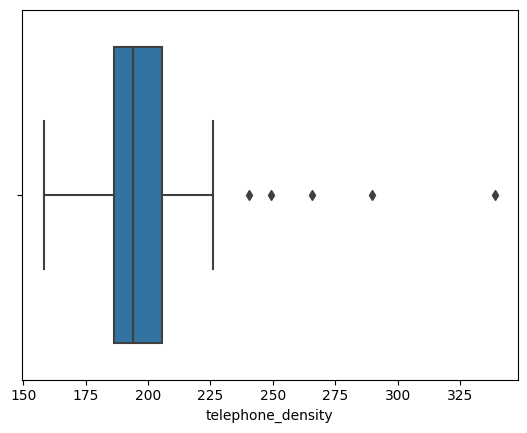

In [30]:
sns.boxplot(x = df["telephone_density"])

In [46]:
df = pd.read_csv('/content/drive/MyDrive/Dano/tele2_dataset.csv', parse_dates=['date', 'event_time'])

<ipython-input-46-5f7a77b58c1c>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Dano/tele2_dataset.csv', parse_dates=['date', 'event_time'])


In [47]:
# Выбираем нужные столбцы для работы
df = df[['campaign', 'client_id', 'session_id', 'event_name', 'region_name', 'age', 'gender']]

# Удалим сессии у которых клиентов больше 1
sorted_df = df[['client_id', 'session_id']].groupby('session_id', as_index=False).agg(lambda x: tuple(set(x.to_list())))
sorted_df = sorted_df[sorted_df['client_id'].apply(lambda x: len(x) > 1)]
sorted_df_list = sorted_df['session_id'].to_list()

df = df[df.session_id.apply(lambda x: x not in sorted_df_list)]

# Переводим рекламу в формат была/не была
df['campaign'] = df['campaign'].apply(lambda x: 0 if x == '(not set)' else 1)

# Переведём даннве в 1 формат
df['client_id'] = df['client_id'].astype(str)
df['region_name'] = df['region_name'].astype(str)

# Заменим регионы принадлежностью к группе
df.region_name = df.region_name.str.replace("SKYLINK", "")
df.region_name = df.region_name.str.replace("NORILSK", "KRASNOYARSK")

df['region_name'] = df.region_name.apply(lambda x: make_reg(x, mini, small, standart, big, largest))

# Заменим ивенты принадлежностью к группе
df['event_name'] = df.event_name.apply(lambda x: make_group(x))

# Количество сессий каждого пользователя
df_cnt = df[['client_id', 'session_id']].drop_duplicates().drop('session_id', axis=1)
df_cnt['summa'] = 1
df_cnt = df_cnt.groupby('client_id', as_index=False).agg('sum')

# Соединяем 2 датасета
df = df.merge(df_cnt, how='right', on='client_id')

<ipython-input-47-33a807091274>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['campaign'] = df['campaign'].apply(lambda x: 0 if x == '(not set)' else 1)
<ipython-input-47-33a807091274>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['client_id'] = df['client_id'].astype(str)
<ipython-input-47-33a807091274>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [48]:
df

,campaign,client_id,session_id,event_name,region_name,age,gender,summa
0,0,0054686833.1667644196,7135922002931679806,1,big_regions,До 18 лет,Male,1
1,0,0067967534.1667760360,2624442888942431926,1,mini_regions,40 - 54 года,Male,1
2,0,0079931750.1667707496,4984392557423944040,5,largest_regions,18 - 24 года,Female,12
3,0,0079931750.1667707496,7113029037596293471,1,largest_regions,18 - 24 года,Female,12
4,0,0079931750.1667707496,288511733141291333,7,largest_regions,18 - 24 года,Female,12
...,...,...,...,...,...,...,...,...
172823,0,999822679.1669502,1736675070876543130,4,big_regions,40 - 54 года,Female,1
172824,0,999822679.1669502,1736675070876543130,4,big_regions,40 - 54 года,Female,1
172825,0,999822679.1669502,1736675070876543130,4,big_regions,40 - 54 года,Female,1
172826,0,999822679.1669502,1736675070876543130,4,big_regions,40 - 54 года,Female,1
